# Analyze Asthma Predictions

This notebook analyzes the predictions from the trained asthma classification model.

**Sections:**
1. Number of patients
   - 1.2 Number of patients for each patient_type
   - 1.2.1 With the number of files per stethoscope
2. Results on train set
   - 2.1 ROC curves
   - 2.2 Confusion matrices
   - 2.3 Precision and recall
3. Results on val set
   - 3.1 ROC curves
   - 3.2 Confusion matrices
   - 3.3 Precision and recall

In [ ]:
# Change to project root directory
%cd ../..

In [ ]:
from pathlib import Path
import os
import sys

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from scipy import stats

from src import config
from src.config import get_experiment_config

%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [ ]:
# Experiment configuration
EXPERIMENT_ID = "asthmoscope_mdpi_2025"
SAMPLE_UNIT_NAME = "splits"

# Cross-validation fold configuration
VAL_FOLD = 0
TEST_FOLD = 1

# Output directories
PRESENTATION_DIR = "PATH/TO/YOUR/PRESENTATION/DIRECTORY"
FIGURES_DIR = os.path.join(PRESENTATION_DIR, 'figures')

# Create output directories
Path(FIGURES_DIR).mkdir(parents=True, exist_ok=True)

print(f"Experiment ID: {EXPERIMENT_ID}")
print(f"Figures will be saved to: {FIGURES_DIR}")

Experiment ID: asthmoscope_mdpi_2025


In [4]:
# Load experiment configuration
config = get_experiment_config(EXPERIMENT_ID)

# Set paths
experiment_out_dir = Path(f"experiments/{EXPERIMENT_ID}/out")
aggregate_dir = experiment_out_dir / "aggregate"

print(f"\nExperiment output directory: {experiment_out_dir}")
print(f"Data files directory: {Path(config['patient_df_path']).parent}")


Experiment output directory: experiments/asthmoscope_mdpi_2025/out
Data files directory: experiments/asthmoscope_mdpi_2025/out/data_files


In [5]:
# Load patient and sample metadata
patient_df = pd.read_csv(config['patient_df_path'])
samples_df = pd.read_csv(config['samples_df_path'])

print(f"Loaded {len(patient_df)} patients")
print(f"Loaded {len(samples_df)} samples")

Loaded 151 patients
Loaded 2024 samples


In [6]:
# Find and load prediction files
if aggregate_dir.exists():
    prediction_files = sorted([f for f in aggregate_dir.glob('*.csv')])
    if prediction_files:
        predictions_filepath = prediction_files[0]
        print(f"\nFound {len(prediction_files)} prediction file(s)")
        print(f"Loading: {predictions_filepath.name}")
    else:
        raise FileNotFoundError(f"No prediction files found in {aggregate_dir}")
else:
    raise FileNotFoundError(f"Aggregate directory not found: {aggregate_dir}")


Found 2 prediction file(s)
Loading: dense_agg_Dasthma_V0.csv


In [7]:
# Load predictions
df = pd.read_csv(predictions_filepath, low_memory=False)

# Prepare prediction columns
df['label'] = df['asthma'].astype(int)
df['output'] = df['output_asthma']
df['predicted_proba'] = df['output']
df['patient_type'] = df['asthma'].replace({0: 'control', 1: 'case'})

# Assign set types based on fold configuration
df['set_type'] = 'train'
df.loc[df['fold'] == VAL_FOLD, 'set_type'] = 'val'
df.loc[df['fold'] == TEST_FOLD, 'set_type'] = 'test'

# Create dataframes for each set
train_df = df[df['set_type'] == 'train'].copy()
val_df = df[df['set_type'] == 'val'].copy()
test_df = df[df['set_type'] == 'test'].copy()

print(f"\nDataset split:")
print(f"  Train: {len(train_df)} samples ({train_df['patient'].nunique()} patients)")
print(f"  Val:   {len(val_df)} samples ({val_df['patient'].nunique()} patients)")
print(f"  Test:  {len(test_df)} samples ({test_df['patient'].nunique()} patients)")
print(f"  Total: {len(df)} samples ({df['patient'].nunique()} patients)")


Dataset split:
  Train: 7440 samples (91 patients)
  Val:   2304 samples (30 patients)
  Test:  2400 samples (30 patients)
  Total: 12144 samples (151 patients)


## 1. Number of patients

In [8]:
n_patients_and_files_df = pd.concat([
    df.groupby("set_type")['patient'].nunique().rename("# patients"),
    df.groupby("set_type").size().rename(f"# {SAMPLE_UNIT_NAME}")
], axis=1).loc[['train', 'val', 'test'], :]

In [9]:
n_patients_and_files_with_total_df = pd.concat([
    n_patients_and_files_df,
    n_patients_and_files_df.sum().rename('Total').to_frame().T
], axis=0)


In [10]:
n_patients_and_files_with_total_df

,# patients,# splits
train,91,7440
val,30,2304
test,30,2400
Total,151,12144


### 1.2 Number of patients for each patient_type

In [11]:
n_patients_and_files_for_each_patient_type_df = pd.concat([
    df.groupby(['set_type', 'patient_type'])['patient'].nunique().rename('# patients'),
    df.groupby(['set_type', 'patient_type']).size().rename(f"# {SAMPLE_UNIT_NAME}")
], axis=1).loc[pd.IndexSlice[['train', 'val', 'test'], :]]

In [12]:
n_patients_and_files_for_each_patient_type_df

# patients  # splits
set_type patient_type                      
train    case                  30      1560
         control               61      5880
val      case                  10       480
         control               20      1824
test     case                  10       528
         control               20      1872

### 1.2.1 With the number of files per stethoscope

In [13]:
n_patients_and_files_and_lit_and_eko_for_each_patient_type_df = pd.concat([
    n_patients_and_files_for_each_patient_type_df,
    df.query("stethoscope == 'L'").groupby(['set_type', 'patient_type']).size().rename('# Lit'),
    df.query("stethoscope == 'E'").groupby(['set_type', 'patient_type']).size().rename('# Eko')
], axis=1).loc[pd.IndexSlice[['train', 'val', 'test'], :]]

In [14]:
n_patients_and_files_and_lit_and_eko_for_each_patient_type_df

# patients  # splits  # Lit  # Eko
set_type patient_type                                    
train    case                  30      1560    516   1044
         control               61      5880   1272   4608
val      case                  10       480    192    288
         control               20      1824    432   1392
test     case                  10       528    192    336
         control               20      1872    480   1392

## 2. Results on train set

In [15]:
set_type = 'train'
set_df = train_df

### 2.1 ROC curves

#### 2.1.1 ROC curve overall

In [16]:
fpr, tpr, thresholds = metrics.roc_curve(set_df['label'], set_df['predicted_proba'])
roc_auc = metrics.roc_auc_score(set_df['label'], set_df['predicted_proba'])

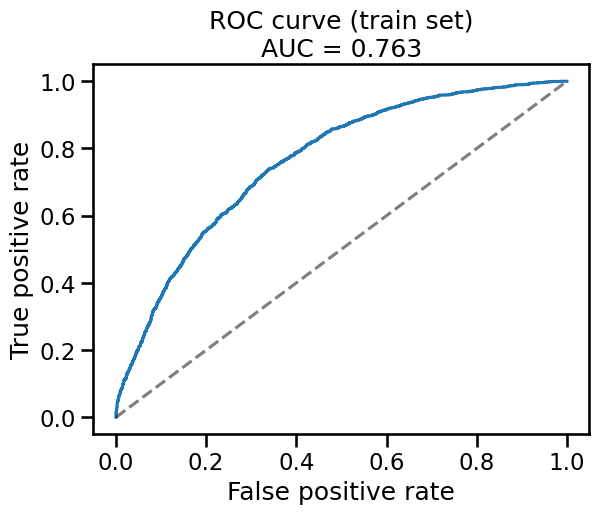

In [17]:
with sns.plotting_context("talk"):
    fig, ax = plt.subplots()
    ax.set_title(f"ROC curve ({set_type} set)\nAUC = {roc_auc:.3f}")
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], '--', color='black', alpha=0.5)
    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True positive rate")

    fig.savefig(os.path.join(FIGURES_DIR, f"roc_plot_{set_type}_set.png"), bbox_inches='tight')

#### 2.1.2 ROC curve for each stethoscope

In [18]:
# Get ROC curves for each stethoscope
stetho_roc_dict = {}
for stethoscope in set_df['stethoscope'].unique():
    df1 = set_df.query("stethoscope == @stethoscope")
    roc_auc = metrics.roc_auc_score(df1['label'], df1['predicted_proba'])
    fpr, tpr, thresholds = metrics.roc_curve(df1['label'], df1['predicted_proba'])
    stetho_roc_dict[stethoscope] = {
        'roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds,
    }

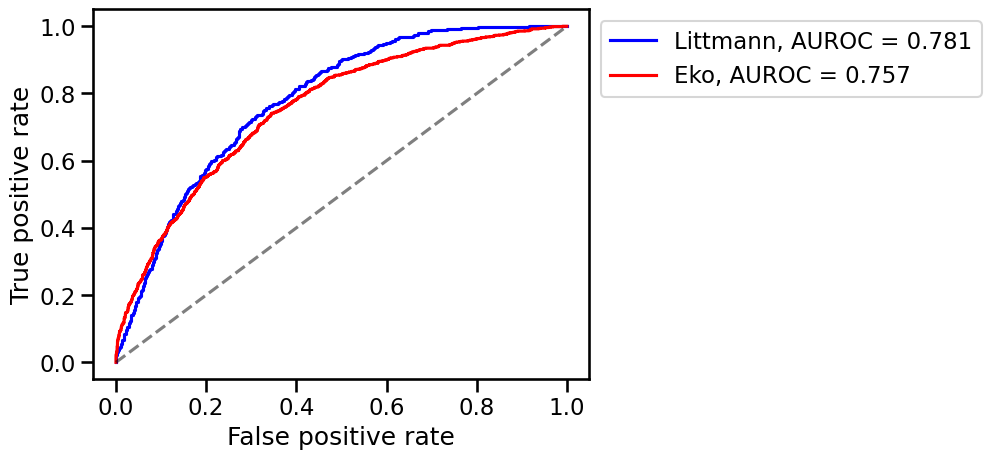

In [19]:
roc_lines_color_dict = {
    'L': 'blue',
    'E': 'red',
}

with sns.plotting_context("talk"):
    fig, ax = plt.subplots()
    # ax.set_title(f"ROC curves for each stethoscope ({set_type} set)")
    for stethoscope in set_df['stethoscope'].unique():
        roc_auc = stetho_roc_dict[stethoscope]['roc_auc']
        fpr = stetho_roc_dict[stethoscope]['fpr']
        tpr = stetho_roc_dict[stethoscope]['tpr']
        
        # Map stethoscope labels
        label_name = 'Littmann' if stethoscope == 'L' else 'Eko'

        ax.plot(fpr, tpr, label=f"{label_name}, AUROC = {roc_auc:.3f}", color=roc_lines_color_dict[stethoscope])
    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True positive rate")
    ax.plot([0, 1], [0, 1], '--', color='black', alpha=0.5)
    ax.legend(bbox_to_anchor=(1, 1))

    fig.savefig(os.path.join(FIGURES_DIR, f"roc_plot_for_each_stethoscope_{set_type}_set_poster_salient.png"), bbox_inches='tight')

#### 2.1.3 T-test AUROC of each stethoscope

In [20]:
n_iter = 1000
# Get ROC curves for each stethoscope
stetho_roc_dict_bootstrap = {}
for stethoscope in set_df['stethoscope'].unique():
    stetho_roc_dict_bootstrap[stethoscope] = []
    df1 = set_df.query("stethoscope == @stethoscope")
    for i in range(n_iter):
        df2 = df1.sample(len(df1), replace=True, random_state=i)
        # df2 = df1.sample(len(df1), replace=True)
        stetho_roc_dict_bootstrap[stethoscope].append(metrics.roc_auc_score(df2['label'], df2['predicted_proba']))
auc_df = pd.DataFrame(stetho_roc_dict_bootstrap)
melted_auc_df = auc_df.melt(var_name='stethoscope', value_name='AUC')

In [21]:
# Perform paired t-test
ttest_results = stats.ttest_ind(auc_df['L'], auc_df['E'])
# t_statistic, p_value, degfreedom = 
print("Paired t-test results:")
print("t-statistic:", ttest_results.statistic)
print(f"p-value: {ttest_results.pvalue:.2e}")

Paired t-test results:
t-statistic: 57.636278883975905
p-value: 0.00e+00


<Axes: xlabel='AUC', ylabel='Count'>

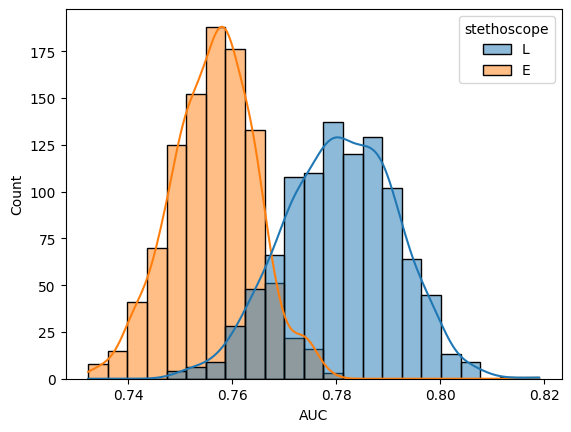

In [22]:
sns.histplot(data=melted_auc_df, x='AUC', hue='stethoscope', kde=True)

### 2.2 Confusion matrices

In [23]:
def create_recording_level_predictions(train_df):
    """
    Create recording-level predictions by aggregating splits using majority vote.
    
    Parameters:
    train_df (pd.DataFrame): DataFrame containing split-level predictions
    
    Returns:
    pd.DataFrame: DataFrame with recording-level predictions
    """
    # Group by file identifier - each unique file represents one recording
    recording_groups = train_df.groupby('file')

    # For each recording, aggregate the predictions
    recording_results = []

    for file, group in recording_groups:
        # Get the true label (should be the same for all splits from the same recording)
        true_label = group['label'].iloc[0]
        
        # Get all predicted probabilities for this recording's splits
        split_probabilities = group['predicted_proba'].values
        
        # Convert probabilities to binary predictions using threshold 0.5
        split_predictions = (split_probabilities >= 0.5).astype(int)
        
        # Majority vote: predict "Asthma" (1) if majority of splits predict "Asthma", 
        # otherwise predict "Control" (0)
        majority_prediction = 1 if split_predictions.sum() >= len(split_predictions) / 2 else 0
        
        recording_results.append({
            'file': file,
            'patient': group['patient'].iloc[0],
            'position': group['position'].iloc[0], 
            'stethoscope': group['stethoscope'].iloc[0],
            'true_label': true_label,
            'predicted_label': majority_prediction,
            'num_splits': len(split_predictions),
            'num_asthma_predictions': split_predictions.sum(),
            'majority_confidence': split_predictions.sum() / len(split_predictions)
        })

    # Convert to DataFrame for easier analysis
    recording_df = pd.DataFrame(recording_results)

    
    return recording_df

In [24]:
def plot_confusion_matrix_for_subset(df_subset, cmap='Blues'):
    """Helper function to plot confusion matrix for a data subset"""
    true_labels = df_subset['true_label']
    predicted_labels = df_subset['predicted_label']
    
    # Create confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    
    # Calculate metrics
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    
    # Create individual figure
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=ax,
                xticklabels=['Control', 'Asthma'],
                yticklabels=['Control', 'Asthma'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    
    return fig, ax, cm, precision, recall

In [25]:
# Call the function to create recording-level predictions
recording_df = create_recording_level_predictions(set_df)
print(f"Number of recordings: {len(recording_df)}")
print(f"Number of splits: {len(set_df)}")
print(f"Average splits per recording: {len(set_df) / len(recording_df):.1f}")

Number of recordings: 1240
Number of splits: 7440
Average splits per recording: 6.0


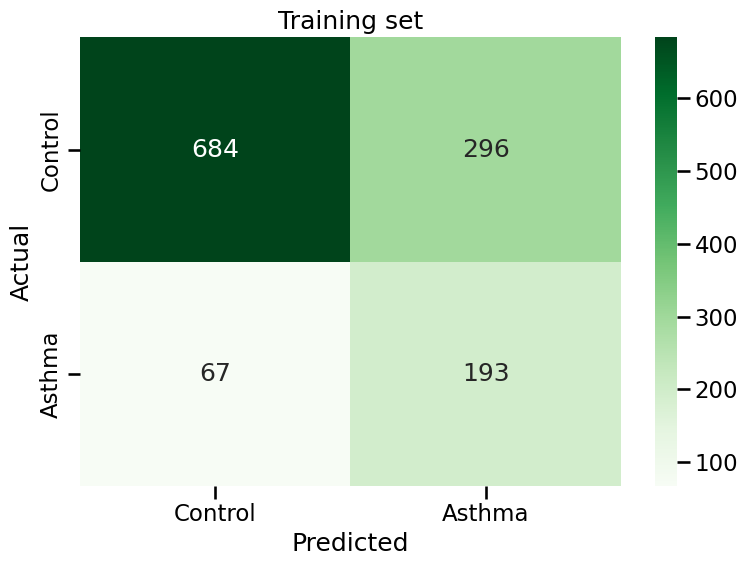

In [26]:
with sns.plotting_context('talk'):
    fig_all, ax_all, cm_all, precision_all, recall_all = plot_confusion_matrix_for_subset(
        recording_df, 'Greens')
    ax_all.set_title(f"Training set")
    plt.tight_layout()
fig_all.savefig(os.path.join(FIGURES_DIR, f"confusion_matrix_{set_type}_set.png"), bbox_inches='tight')

### 2.3 Precision and recall

In [27]:
# Calculate metrics for overall recording_df
predictions = recording_df['predicted_label']
labels = recording_df['true_label']

overall_precision = precision_score(labels, predictions)
overall_recall = recall_score(labels, predictions)
overall_specificity = recall_score(labels, predictions, pos_label=0)

# Calculate metrics for Eko stethoscope (E)
recording_df_eko = recording_df[recording_df['stethoscope'] == 'E']
eko_predictions = recording_df_eko['predicted_label']
eko_labels = recording_df_eko['true_label']

eko_precision = precision_score(eko_labels, eko_predictions)
eko_recall = recall_score(eko_labels, eko_predictions)
eko_specificity = recall_score(eko_labels, eko_predictions, pos_label=0)

# Calculate metrics for Littmann stethoscope (L)
recording_df_littmann = recording_df[recording_df['stethoscope'] == 'L']
littmann_predictions = recording_df_littmann['predicted_label']
littmann_labels = recording_df_littmann['true_label']

littmann_precision = precision_score(littmann_labels, littmann_predictions)
littmann_recall = recall_score(littmann_labels, littmann_predictions)
littmann_specificity = recall_score(littmann_labels, littmann_predictions, pos_label=0)

# Create the metrics DataFrame
metrics_df = pd.DataFrame({
    'E': [eko_precision, eko_recall, eko_specificity],
    'L': [littmann_precision, littmann_recall, littmann_specificity],
    'overall': [overall_precision, overall_recall, overall_specificity]
}, index=['Precision', 'Recall', 'Specificity'])

print("Train Set Metrics by Stethoscope Type:")
print("=" * 45)
print(metrics_df.round(3))
metrics_df

Train Set Metrics by Stethoscope Type:
                 E      L  overall
Precision    0.357  0.508    0.395
Recall       0.753  0.721    0.742
Specificity  0.693  0.717    0.698


,E,L,overall
Precision,0.356948,0.508197,0.394683
Recall,0.752874,0.720930,0.742308
Specificity,0.692708,0.716981,0.697959


## 3. Results on val set

In [28]:
set_type = 'val'
set_df = val_df

### 3.1 ROC curves

#### 3.1.1 ROC curve overall

In [29]:
fpr, tpr, thresholds = metrics.roc_curve(set_df['label'], set_df['predicted_proba'])
roc_auc = metrics.roc_auc_score(set_df['label'], set_df['predicted_proba'])

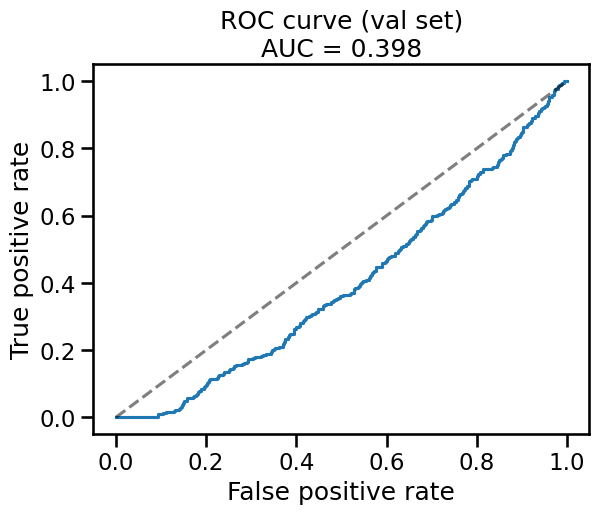

In [30]:
with sns.plotting_context("talk"):
    fig, ax = plt.subplots()
    ax.set_title(f"ROC curve ({set_type} set)\nAUC = {roc_auc:.3f}")
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], '--', color='black', alpha=0.5)
    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True positive rate")

    fig.savefig(os.path.join(FIGURES_DIR, f"roc_plot_{set_type}_set.png"), bbox_inches='tight')

#### 3.1.2 ROC curve for each stethoscope

In [31]:
# Get ROC curves for each stethoscope
stetho_roc_dict = {}
for stethoscope in set_df['stethoscope'].unique():
    df1 = set_df.query("stethoscope == @stethoscope")
    roc_auc = metrics.roc_auc_score(df1['label'], df1['predicted_proba'])
    fpr, tpr, thresholds = metrics.roc_curve(df1['label'], df1['predicted_proba'])
    stetho_roc_dict[stethoscope] = {
        'roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds,
    }

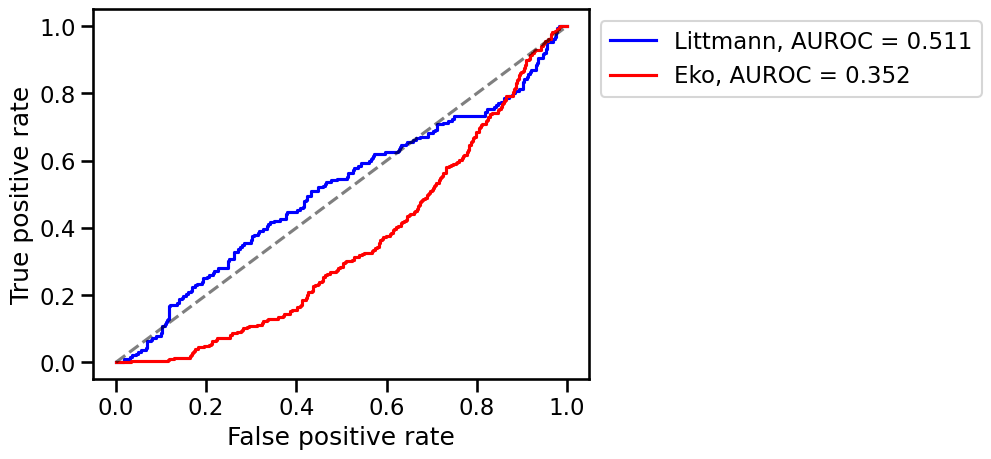

In [32]:
roc_lines_color_dict = {
    'L': 'blue',
    'E': 'red',
}

with sns.plotting_context("talk"):
    fig, ax = plt.subplots()
    # ax.set_title(f"ROC curves for each stethoscope ({set_type} set)")
    for stethoscope in set_df['stethoscope'].unique():
        roc_auc = stetho_roc_dict[stethoscope]['roc_auc']
        fpr = stetho_roc_dict[stethoscope]['fpr']
        tpr = stetho_roc_dict[stethoscope]['tpr']
        # Map stethoscope labels
        label_name = 'Littmann' if stethoscope == 'L' else 'Eko'

        ax.plot(fpr, tpr, label=f"{label_name}, AUROC = {roc_auc:.3f}", color=roc_lines_color_dict[stethoscope])
    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True positive rate")
    ax.plot([0, 1], [0, 1], '--', color='black', alpha=0.5)
    ax.legend(bbox_to_anchor=(1, 1))

    fig.savefig(os.path.join(FIGURES_DIR, f"roc_plot_for_each_stethoscope_{set_type}_set_poster_salient.png"), bbox_inches='tight')

#### 3.1.3 T-test AUROC of each stethoscope

In [33]:
n_iter = 1000
# Get ROC curves for each stethoscope
stetho_roc_dict_bootstrap = {}
for stethoscope in set_df['stethoscope'].unique():
    stetho_roc_dict_bootstrap[stethoscope] = []
    df1 = set_df.query("stethoscope == @stethoscope")
    for i in range(n_iter):
        df2 = df1.sample(len(df1), replace=True, random_state=i)
        # df2 = df1.sample(len(df1), replace=True)
        stetho_roc_dict_bootstrap[stethoscope].append(metrics.roc_auc_score(df2['label'], df2['predicted_proba']))
auc_df = pd.DataFrame(stetho_roc_dict_bootstrap)
melted_auc_df = auc_df.melt(var_name='stethoscope', value_name='AUC')

In [34]:
# Perform paired t-test
ttest_results = stats.ttest_ind(auc_df['L'], auc_df['E'])
# t_statistic, p_value, degfreedom = 
print("Paired t-test results:")
print("t-statistic:", ttest_results.statistic)
print(f"p-value: {ttest_results.pvalue:.2e}")

Paired t-test results:
t-statistic: 160.85139010967023
p-value: 0.00e+00


<Axes: xlabel='AUC', ylabel='Count'>

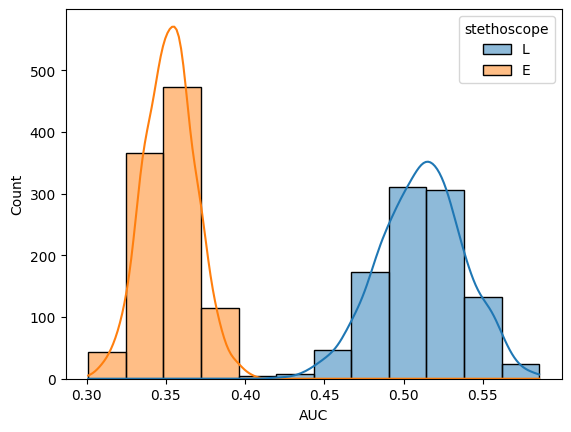

In [35]:
sns.histplot(data=melted_auc_df, x='AUC', hue='stethoscope', kde=True)

### 3.2 Confusion matrices

In [36]:
# Call the function to create recording-level predictions
recording_df = create_recording_level_predictions(set_df)
print(f"Number of recordings: {len(recording_df)}")
print(f"Number of splits: {len(set_df)}")
print(f"Average splits per recording: {len(set_df) / len(recording_df):.1f}")

Number of recordings: 384
Number of splits: 2304
Average splits per recording: 6.0


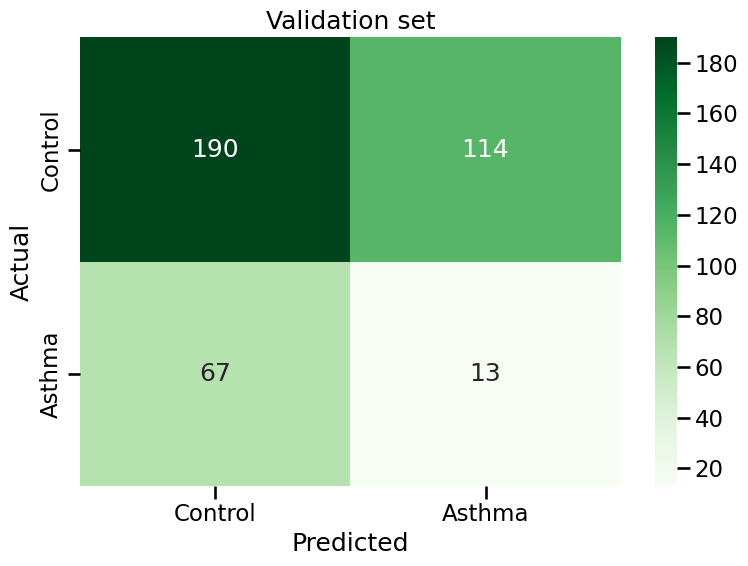

In [37]:
with sns.plotting_context('talk'):
    fig_all, ax_all, cm_all, precision_all, recall_all = plot_confusion_matrix_for_subset(
        recording_df, 'Greens')
    ax_all.set_title(f"Validation set")
    plt.tight_layout()
fig_all.savefig(os.path.join(FIGURES_DIR, f"confusion_matrix_{set_type}_set.png"), bbox_inches='tight')

### 3.3 Precision and recall

In [38]:
# Calculate metrics for overall recording_df
predictions = recording_df['predicted_label']
labels = recording_df['true_label']

overall_precision = precision_score(labels, predictions)
overall_recall = recall_score(labels, predictions)
overall_specificity = recall_score(labels, predictions, pos_label=0)

# Calculate metrics for Eko stethoscope (E)
recording_df_eko = recording_df[recording_df['stethoscope'] == 'E']
eko_predictions = recording_df_eko['predicted_label']
eko_labels = recording_df_eko['true_label']

eko_precision = precision_score(eko_labels, eko_predictions)
eko_recall = recall_score(eko_labels, eko_predictions)
eko_specificity = recall_score(eko_labels, eko_predictions, pos_label=0)

# Calculate metrics for Littmann stethoscope (L)
recording_df_littmann = recording_df[recording_df['stethoscope'] == 'L']
littmann_predictions = recording_df_littmann['predicted_label']
littmann_labels = recording_df_littmann['true_label']

littmann_precision = precision_score(littmann_labels, littmann_predictions)
littmann_recall = recall_score(littmann_labels, littmann_predictions)
littmann_specificity = recall_score(littmann_labels, littmann_predictions, pos_label=0)

# Create the metrics DataFrame
metrics_df = pd.DataFrame({
    'E': [eko_precision, eko_recall, eko_specificity],
    'L': [littmann_precision, littmann_recall, littmann_specificity],
    'overall': [overall_precision, overall_recall, overall_specificity]
}, index=['Precision', 'Recall', 'Specificity'])

print("Train Set Metrics by Stethoscope Type:")
print("=" * 45)
print(metrics_df.round(3))
metrics_df

Train Set Metrics by Stethoscope Type:
                 E      L  overall
Precision    0.039  0.360    0.102
Recall       0.083  0.281    0.162
Specificity  0.578  0.778    0.625


,E,L,overall
Precision,0.039216,0.360000,0.102362
Recall,0.083333,0.281250,0.162500
Specificity,0.577586,0.777778,0.625000
